In our first notebook, we performed analyses on the Google Play Store dataset. 

In this notebook, we will combine said dataset with others. We will explore the following questions: 
    
 - Are there differences, in terms of rating and the number of ratings, for an app depending on where it is published? (Google Play Store versus Apple App Store)
    - Why? Explore a particular case. 
 - Does there exist a relationship between 'positive' reviews and higher ratings? 
    - Do apps with 'positive' reviews have higher ratings than apps that do have 'negative' reviews? 
    - Are there users who have left a high rating but a 'negative' review? Why? 
    - Do ratings that are extremely positive or extremely negative garner more 'likes' than ratings that are more on the neutral side? 
    - Do users leave a mixture of positive and negative reviews, or do users leave negative reviews that are only negative or only positive?

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import ipywidgets as widgets
import re
import difflib
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import f_oneway

In [2]:
sns.set()
palette = sns.color_palette('Set2')
# From https://stackoverflow.com/questions/39680147/can-i-set-variable-column-widths-in-pandas
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 400)

In [3]:
google_apps = pd.read_csv(r'Google Play Store Apps.zip')

In [4]:
google_apps.head()

,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,Price,...,Developer Website,Developer Email,Released,Last Updated,Content Rating,Privacy Policy,Ad Supported,In App Purchases,Editors Choice,Scraped Time
0,Gakondo,com.ishakwe.gakondo,Adventure,0.0,0.0,10+,10.0,15,True,0.0,...,https://beniyizibyose.tk/#/,jean21101999@gmail.com,"Feb 26, 2020","Feb 26, 2020",Everyone,https://beniyizibyose.tk/projects/,False,False,False,2021-06-15 20:19:35
1,Ampere Battery Info,com.webserveis.batteryinfo,Tools,4.4,64.0,"5,000+",5000.0,7662,True,0.0,...,https://webserveis.netlify.app/,webserveis@gmail.com,"May 21, 2020","May 06, 2021",Everyone,https://dev4phones.wordpress.com/licencia-de-uso/,True,False,False,2021-06-15 20:19:35
2,Vibook,com.doantiepvien.crm,Productivity,0.0,0.0,50+,50.0,58,True,0.0,...,NaN,vnacrewit@gmail.com,"Aug 9, 2019","Aug 19, 2019",Everyone,https://www.vietnamairlines.com/vn/en/terms-and-conditions/privacy-policy,False,False,False,2021-06-15 20:19:35
3,Smart City Trichy Public Service Vehicles 17UCS548,cst.stJoseph.ug17ucs548,Communication,5.0,5.0,10+,10.0,19,True,0.0,...,http://www.climatesmarttech.com/,climatesmarttech2@gmail.com,"Sep 10, 2018","Oct 13, 2018",Everyone,NaN,True,False,False,2021-06-15 20:19:35
4,GROW.me,com.horodyski.grower,Tools,0.0,0.0,100+,100.0,478,True,0.0,...,http://www.horodyski.com.pl,rmilekhorodyski@gmail.com,"Feb 21, 2020","Nov 12, 2018",Everyone,http://www.horodyski.com.pl,False,False,False,2021-06-15 20:19:35


In [5]:
google_apps.shape

(2312944, 24)

Next, we will investigate if there a difference in the number of ratings (as well as the rating itself) for identical apps published on the Google Play Store versus the Apple App Store.

In [6]:
apple_apps = pd.read_csv(r'Apple App Store Apps.zip')

In [7]:
apple_apps.head()

,App_Id,App_Name,AppStore_Url,Primary_Genre,Content_Rating,Size_Bytes,Required_IOS_Version,Released,Updated,Version,...,Currency,Free,DeveloperId,Developer,Developer_Url,Developer_Website,Average_User_Rating,Reviews,Current_Version_Score,Current_Version_Reviews
0,com.hkbu.arc.apaper,A+ Paper Guide,https://apps.apple.com/us/app/a-paper-guide/id1277517387?uo=4,Education,4+,21993472.0,8.0,2017-09-28T03:02:41Z,2018-12-21T21:30:36Z,1.1.2,...,USD,True,1375410542,HKBU ARC,https://apps.apple.com/us/developer/hkbu-arc/id1375410542?uo=4,NaN,0.0,0,0.0,0
1,com.dmitriev.abooks,A-Books,https://apps.apple.com/us/app/a-books/id1031572002?uo=4,Book,4+,13135872.0,10.0,2015-08-31T19:31:32Z,2019-07-23T20:31:09Z,1.3,...,USD,True,1031572001,Roman Dmitriev,https://apps.apple.com/us/developer/roman-dmitriev/id1031572001?uo=4,NaN,5.0,1,5.0,1
2,no.terp.abooks,A-books,https://apps.apple.com/us/app/a-books/id1457024164?uo=4,Book,4+,21943296.0,9.0,2021-04-14T07:00:00Z,2021-05-30T21:08:54Z,1.3.1,...,USD,True,1457024163,Terp AS,https://apps.apple.com/us/developer/terp-as/id1457024163?uo=4,NaN,0.0,0,0.0,0
3,fr.antoinettefleur.Book1,A-F Book #1,https://apps.apple.com/us/app/a-f-book-1/id500454885?uo=4,Book,4+,81851392.0,8.0,2012-02-10T03:40:07Z,2019-10-29T12:40:37Z,1.2,...,USD,False,439568839,i-editeur.com,https://apps.apple.com/us/developer/i-editeur-com/id439568839?uo=4,NaN,0.0,0,0.0,0
4,com.imonstersoft.azdictionaryios,A-Z Synonyms Dictionary,https://apps.apple.com/us/app/a-z-synonyms-dictionary/id1545096265?uo=4,Reference,4+,64692224.0,9.0,2020-12-16T08:00:00Z,2020-12-18T21:36:11Z,1.0.1,...,USD,True,656731821,Ngov chiheang,https://apps.apple.com/us/developer/ngov-chiheang/id656731821?uo=4,http://imonstersoft.com,0.0,0,0.0,0


In [8]:
apple_apps.shape

(1230376, 21)

Since apps on the Apple App Store store a separate identification ID in the url, we need to extract this because this is requred as input for scraping reviews later. 

In [9]:
pattern = re.compile(r'^.*/id(\d+).*$')
def extract_url_id(url): 
    match = pattern.match(url)
    if match: 
        return match[1]
    else: 
        return np.nan 

In [10]:
apple_apps['Url Id'] = apple_apps['AppStore_Url'].apply(lambda x: extract_url_id(x))

In [11]:
google_apps = google_apps[['App Id', 'App Name', 'Developer Id', 'Rating', 'Released', 'Rating Count']].copy()
apple_apps = apple_apps[['App_Id', 'App_Name', 'Developer', 'Current_Version_Score', 'Released', 'Reviews', 'Url Id']].copy()

In [12]:
apple_apps.rename(columns={'App_Id': 'App Id', 
                           'App_Name': 'App Name',
                           'Developer': 'Apple Developer', 
                           'Current_Version_Score': 'Apple Rating', 
                           'Released': 'Apple Released', 
                           'Reviews': 'Apple Rating Count'
                          }, 
                  errors='raise', inplace=True)

google_apps.rename(columns={'Rating': 'Google Rating', 
                            'Developer Id': 'Google Developer',
                            'Released': 'Google Released', 
                            'Rating Count': 'Google Rating Count'},
                  errors='raise', inplace=True)

In [13]:
combined_apps = google_apps.merge(apple_apps, on=['App Name','App Id'], how='inner')

In [14]:
def remove_nonmatching_developers(apple_dev, google_dev): 
    sequence = difflib.SequenceMatcher(a=apple_dev, b=google_dev)
    
    # Measure of similarity 
    similarity = sequence.ratio()
    if similarity > 0.6:
        return google_dev # Arbitrary return one of the names
    else: 
        return np.nan

In [15]:
# To ensure that the apps' developers on the Google Play Store and the Apple App Store are the same, we will test for similairity 
combined_apps['Developer'] = combined_apps.apply(lambda x: 
                                                 remove_nonmatching_developers(x['Google Developer'], x['Apple Developer']), 
                                                 axis=1)
combined_apps.dropna(subset=['Developer'], inplace=True)

Now let's visualize the distribution of ratings of the Google Play Store and the Apple App Store

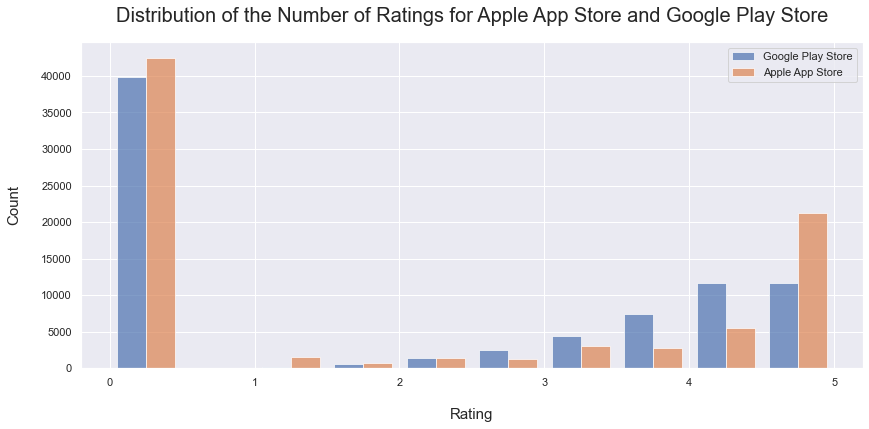

In [16]:
figure = plt.figure(figsize=(14, 6))
axis = plt.gca()
plt.hist([combined_apps['Google Rating'], combined_apps['Apple Rating']], alpha=0.7)
plt.xlabel('Rating', fontsize=15, labelpad=20)
plt.ylabel('Count', fontsize=15, labelpad=20)
plt.legend(['Google Play Store', 'Apple App Store'])
plt.title('Distribution of the Number of Ratings for Apple App Store and Google Play Store', fontsize=20, pad=20)
plt.show()

It appears that when we consider identical apps published on Google Play Store and Apple App Store, the latter has more apps that are not rated (0 rating) in addition to having more apps with a (near) 5 star rating! 

Why would the same app yield different ratings? 

As we explore this question, we will look at the reviews for these applications as well. 

In [17]:
# combined_apps = combined_apps.sample(n=10000, random_state=42) 

In [18]:
# combined_apps.to_csv('Apps Joined')

Before we proceeded, we used our scraper program to scrape (up to) 100 Google Play Store reviews for all apps in the combined_apps data frame. That has already been done and the csv is stored as 'google_app_reviews.csv', so we can read it in with Pandas. 

Additionally, we could not scrape many reviews on this scale from the Apple App Store, as our IP was blocked after only approximately ~500 reviews. 

We also used the TextBlob library to compute a sentiment polarity score for each review. 

Let's find apps with the largest differences in rating betweeen the Google App Store and the Apple App Store. 

In [19]:
combined_apps['Rating Difference'] = abs(combined_apps['Google Rating'] - combined_apps['Apple Rating'])

It appears that a large discrepancy can be caused if there are, say no ratings for the app on the Apple App Store but there is a 5 star rating on the Google Play Store. 

We will filter out such cases by considering apps that have at least 100 ratings in both stores. 

In [20]:
combined_apps_popular = combined_apps[(combined_apps['Google Rating Count'] > 100) & (combined_apps['Apple Rating Count'] > 100)].copy()
combined_apps_popular.sort_values(by=['Rating Difference'], ascending=False, inplace=True)

Let's analyze the top ten apps that have the highest rating differences between the two platforms

In [21]:
combined_apps_ten = combined_apps_popular.head(10)
combined_apps_ten

,App Id,App Name,Google Developer,Google Rating,Google Released,Google Rating Count,Apple Developer,Apple Rating,Apple Released,Apple Rating Count,Url Id,Developer,Rating Difference
53270,com.fanduel.scout,FanDuel Scout,FanDuel,1.8,"Sep 6, 2017",2228.0,"FanDuel, Inc.",4.73857,2017-09-07T00:47:41Z,13973,1275873422,"FanDuel, Inc.",2.93857
9760,co.mixcord.acapella,Acapella from PicPlayPost,Mixcord Inc,1.7,"Feb 5, 2016",2636.0,Mixcord Inc.,4.59440,2015-09-15T03:43:15Z,22870,924635678,Mixcord Inc.,2.89440
77051,com.mtvn.RateMyProfessors,Rate My Professors,Cheddar Inc,2.0,"Jan 24, 2017",184.0,Cheddar Inc,4.86472,2010-01-06T21:12:01Z,16092,345381821,Cheddar Inc,2.86472
32756,com.atomiccu.ios1,Atomic Credit Union,Atomic Credit Union,1.8,"Apr 12, 2021",108.0,Atomic Credit Union,4.61990,2016-02-19T15:16:08Z,1447,1085742428,Atomic Credit Union,2.81990
77815,com.punchh.smashburger,Smashburger Rewards,Smashburger/JFC,1.8,"Mar 20, 2017",1250.0,Smashburger,4.57090,2017-03-21T00:12:21Z,1361,1207759409,Smashburger,2.77090
20255,com.walottery.mobileapp,Washington's Lottery,Scientific Games Corporation,4.2,"Nov 11, 2014",2770.0,Scientific Games International,1.56195,2015-05-23T10:00:15Z,678,952379144,Scientific Games International,2.63805
105375,com.GPC.OCCMobile,Georgia Power,Georgia Power Company,4.0,"Sep 22, 2014",1065.0,Georgia Power Company,1.39959,2014-08-25T16:10:13Z,483,905338462,Georgia Power Company,2.60041
118242,com.axiemsystems.photoeditor,Photo Editor+,Axiem Systems,2.1,"Sep 7, 2012",1023.0,Axiem Systems,4.68119,2012-02-09T18:36:50Z,1468,499146288,Axiem Systems,2.58119
13903,com.flolivingalisavitti.myfloapp,MyFLO Period Tracker,FLO Living LLC,2.1,"Jan 23, 2017",896.0,Flo Living,4.65041,2016-11-17T08:18:12Z,10086,1152657123,Flo Living,2.55041
117812,com.morganstanley.prod.SumSPC,StockPlan Connect,Morgan Stanley and Co. LLC,2.0,"Feb 14, 2019",320.0,Morgan Stanley,4.54538,2019-02-16T19:39:49Z,4815,1354023603,Morgan Stanley,2.54538


Wow! The highest app has a 2.93857 rating discrepancy! We note that there are a lot more ratings on the Apple App Store for this app, but the number of ratings on the Google Play Store is not small either. 

Looking at this list, it seems Apple has the higher rating for most of the apps. This supports the previously displayed graph -- there is a larger number of higher ratings on Apple's App Store. 

Before we proceeded, we scraped (up to) 100 reviews for each app in the combined_apps_ten dataframe from the Apple App Store. We've also computed a sentiment polarity score for each review using TextBlob. The csv is saved as 'apple_app_reviews.csv' so we can read it with Pandas. 

In [22]:
reviews_google = pd.read_csv('google_app_reviews_aa')
reviews_google.rename(columns={'app_id': 'App Id'}, errors='raise', inplace=True)

# Combine it with the larger dataframe that includes all the reviews, so we can get the rating
reviews_google_selected = combined_apps_ten.merge(reviews_google, on=['App Id'], how='inner')

In [23]:
reviews_apple_selected = pd.read_csv('apple_app_reviews.csv')
reviews_apple_selected.rename(columns={'app_id': 'App Id'}, errors='raise', inplace=True)

In [24]:
google_polarity_avg = reviews_google_selected.groupby(by=['App Id', 'App Name']).mean('polarity')
apple_polarity_avg = reviews_apple_selected.groupby(by=['App Id']).mean('Polarity')

In [25]:
apple_polarity_avg.rename(columns={'score': 'Apple Score', 'Polarity': 'Apple Polarity'}, inplace=True)
apple_polarity_avg.drop(columns=['Unnamed: 0'], inplace=True)
apple_polarity_avg.reset_index(inplace=True)

In [26]:
google_polarity_avg.rename(columns={'score': 'Google Score', 'likes': 'Google Likes', 'polarity': 'Google Polarity'}, inplace=True)
google_polarity_avg.drop(columns=['Unnamed: 0'], inplace=True)
google_polarity_avg.reset_index(inplace=True)

In [27]:
polarity_combined = google_polarity_avg.merge(apple_polarity_avg, on='App Id', how='inner')

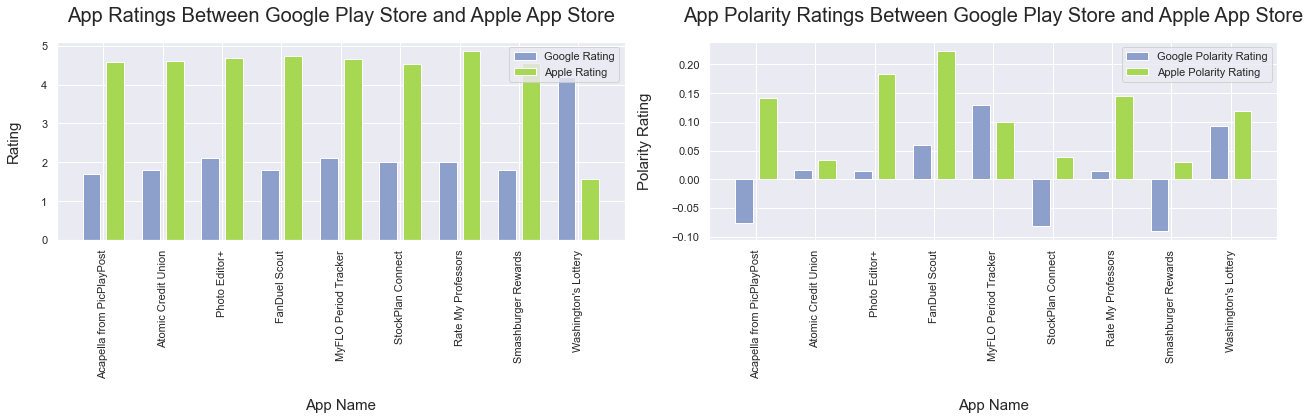

In [28]:
figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=(18, 6))

# Inspired from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(9)
width = 0.3
google_ratings = polarity_combined['Google Rating']
apple_ratings = polarity_combined['Apple Rating']

google_polarities = polarity_combined['Google Polarity']
apple_polarities = polarity_combined['Apple Polarity']

axis_1.set_xlabel('App Name', fontsize=15, labelpad=20)
axis_1.set_ylabel('Rating', fontsize=15, labelpad=20)
axis_1.set_title('App Ratings Between Google Play Store and Apple App Store', fontsize=20, pad=20)

axis_1.bar(x-0.2, google_ratings, width, label='Google Rating', color=palette[2])
axis_1.bar(x+0.2, apple_ratings, width, label='Apple Rating', color=palette[4])
axis_1.legend()

axis_2.set_xlabel('App Name', fontsize=15, labelpad=20)
axis_2.set_ylabel('Polarity Rating', fontsize=15, labelpad=20)
axis_2.set_title('App Polarity Ratings Between Google Play Store and Apple App Store', fontsize=20, pad=20)

axis_2.bar(x-0.2, google_polarities, width, label='Google Polarity Rating', color=palette[2])
axis_2.bar(x+0.2, apple_polarities, width, label='Apple Polarity Rating', color=palette[4])
axis_2.legend()

axis_1.set_xticks(ticks=polarity_combined.index)
axis_1.set_xticklabels(labels=polarity_combined['App Name'],
                       rotation=90)

axis_2.set_xticks(ticks=polarity_combined.index)
axis_2.set_xticklabels(labels=polarity_combined['App Name'], 
                       rotation=90)

# From https://www.kite.com/python/answers/how-to-set-the-spacing-between-subplots-in-matplotlib-in-python
figure.tight_layout()

Comparing the sentiment polarities and the ratings, we can see that the lower the rating the lower the sentiment polarity.

In almost all these apps, it is rated lower on the Google Play Store. As a consequence, the polarity is lower too. 

Let's take a closer look at some of the reviews for FanDuel Scout -- the app with the largest rating discrepancy between the two platforms. 

In [29]:
fanduel_google = reviews_google[reviews_google['App Id'] == 'com.fanduel.scout'].copy()
fanduel_google.sort_values(by=['likes'], ascending=False, inplace=True)
fanduel_google[['content', 'likes']].head(5)

,content,likes
391855,"I can't even use the app right now. I'm trying to use it for MLB and it won't let me sign in. Says my email or password is wrong, even though I'm using the same email and password I use for FanDuel. I finally got in after changing my password and it said JT Realmuto was injured and not starting, and a simple Google search showed that the Phillies have him starting. Then I closed app and reopen...",53
391797,"When it works it's great, BUT just like everyone else it will not login even though I am using the correct login and password. I have even changed my password to be sure of it. I wish there was a way you could contact anyone to correct this problem because it is very annoying...real money on the line, and my tools are broken. Looks like we have a claim to get reimbursement on any monies lost.....",51
391796,"It never has the correct info for my login. I had the password right and it wouldn't accept it, then I changed my password and put the new password in and it's somehow incorrect. This happens over and over again. Update: 10/24/20 I'm changing from 2 stars to 1 star because they have done nothing to correct the issue or communicate with those having issues.",50
391823,"App keeps signing me out even though i'm signed in on the fanduel app. When I type in my username and password, it tells me that it's wrong. Can someone please help resolve this issue. Without this issue, I would rate 5 stars for the up to date news and articles.",37
391810,"I would give it ZERO stars if it allowed me to. This app used to be great, now I can't log in too it, I even changed my password, still unable to log in. I emailed Fanduel, they said that they were aware of issues, that was nearly 6 months ago, still not fixed, COME ON Fanduel, get your act together!",35


Taking a look at the top three most-liked reviews, it seems that the poor reviews stem from usability of the application and the lack of resolution. 

When we look at the same app on the Apple App Store: (There is no option to 'like' reviews on the Apple App Store so we cannot sort by likes)

In [30]:
fanduel_apple = reviews_apple_selected[(reviews_apple_selected['App Id'] == 'com.fanduel.scout')].copy()
fanduel_apple.head(5)

,Unnamed: 0,App Id,user_name,rating,content,Polarity
248,248,com.fanduel.scout,slkkblack,5,It helps me out on last minute rotations. Awesome,0.5
251,251,com.fanduel.scout,GoKuSeN3,5,Helpful tool but pages have updated in a couple days,0.0
252,252,com.fanduel.scout,ORLFlight,5,Helps me keep up with the breaking news.,0.0
253,253,com.fanduel.scout,Tmanbigdog,5,App is great when it doesn’t freeze,0.8
254,254,com.fanduel.scout,kimmyk40,5,I canceled my subscription the same day!! I want a refund!!!!!!,0.0


Indeed, there are 1-star reviews as well that are releated to the (lack of) usability of the app. 

We proceed to make visualziation of the the distribution of reviews for this app:

In [31]:
count_fanduel_apple = fanduel_apple.groupby(by=['rating']).count().reset_index()
count_fanduel_google = fanduel_google.groupby(by=['score']).count().reset_index()

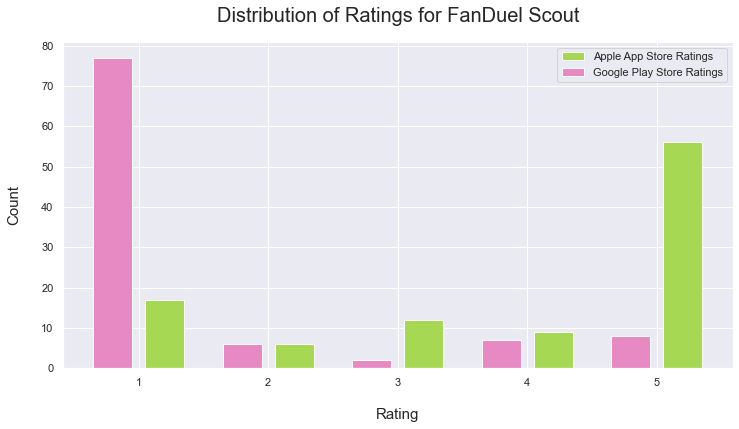

In [32]:
figure = plt.figure(figsize=(12,6))
axis = plt.gca()

apple_fanduel = count_fanduel_apple['App Id'] # This is the count
google_fanduel = count_fanduel_google['App Id']

# Inspired from https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
x = np.arange(5)
width = 0.3

axis.bar(x+0.2, apple_fanduel, width, label='Apple App Store Ratings', color=palette[4])
axis.bar(x-0.2, google_fanduel, width, label='Google Play Store Ratings', color=palette[3])
axis.legend()

axis.set_xlabel('Rating', fontsize=15, labelpad=20)
axis.set_ylabel('Count', fontsize=15, labelpad=20)
axis.set_title('Distribution of Ratings for FanDuel Scout', fontsize=20, pad=20)

axis.set_xticks(ticks=count_fanduel_google.index)
axis.set_xticklabels(labels=count_fanduel_google['score'])

plt.show()

We can see that there is an overwhelming number of 1-star reviews on the Google Play Store for FanDuel Scout. 

Perhaps the app malfunctions on the Android platform more often than on iOS. 

We return to our dataframe of google reviews and take a look at the most liked 1-star ratings. 

In [33]:
reviews_google = reviews_google[reviews_google['score'] > 0].copy()
reviews_google.sort_values(by=['score', 'likes'], ascending=[True, False], inplace=True)
reviews_google.head()

,Unnamed: 0,App Id,user_name,score,content,likes,polarity
551281,0.0,com.imangi.templerun2,Ally Cat,1,I had to delete the app. I don't understand how it works and i tried so that my siblings and cousins could play as well but the new visuals are puzzling and makes us dizzy.,19119,0.136364
98207,0.0,com.outfit7.talkingtom,Jennifer Spiers,1,Ads every couple minutes. I'd be willing to pay for the app just to not have adds. It's impossible for my toddler to play with the ads popping up so frequently.,16620,-0.105556
476957,0.0,com.imangi.templerun,Mitchell Downs,1,At the end of your run it will ask would you like to watch an advertisement to continue you run. You decide no I don't want to watch an advertisement and you end your run to start over. They immediately make you watch an advertisement ANYWAY before they let you start anew. Pathetic! Literally makes you watch ads every time. The game is way to rudimentary for that to be honest. Don't waste your...,15820,-0.250000
472463,0.0,com.igoldtech.streetchaser,Ajiboye Kayode,1,"One star game! Can't give more than that. How can everything make you fall and you have to start all over, even if you were chasing the 10th thief? The graphic is poor - so confusing. All the thief coming from opposite can fall you, but you can't do anything to them. The game is designed with money in view. They just want to make money",12831,-0.157143
311832,0.0,com.ketchapp.fruitmaster,Paint with Eugine,1,I really hate this game..BORING!!! I played this for so many times but I dont see any changes from level 1 to level 125 no fun no adventure in every level thats why its boring. And also in the claim reward portion I never win instruments since level 1 to 125 I hate this app...I wasted most of my time...,12046,-0.318750


It appears that the most liked 1-star reviews stem from annoyance due to advertisements and game usabilitity. 

Next we will investigate if there is a correlation between average review sentiment polarity and the rating of the app. 

In [34]:
reviews_google = reviews_google.merge(google_apps, on=['App Id'], how='inner')

grouped_reviews_google = reviews_google.groupby(by=['App Id', 'Google Rating']).agg(mean_polarity=('polarity', 'mean'), mean_score=('score', 'mean'))
grouped_reviews_google.reset_index(inplace=True)

In [35]:
grouped_reviews_google =  grouped_reviews_google[grouped_reviews_google['Google Rating'] > 0].copy()

In [36]:
r, p = stats.pearsonr(grouped_reviews_google['mean_polarity'], grouped_reviews_google['mean_score'])
r, p

(0.6413094370449159, 0.0)

And as expected, we observe a linear association between rating and sentiment polarity. We are confident in this claim due to the miniscule pvalue.

Let's see a scatter plot with a best-fit line. 

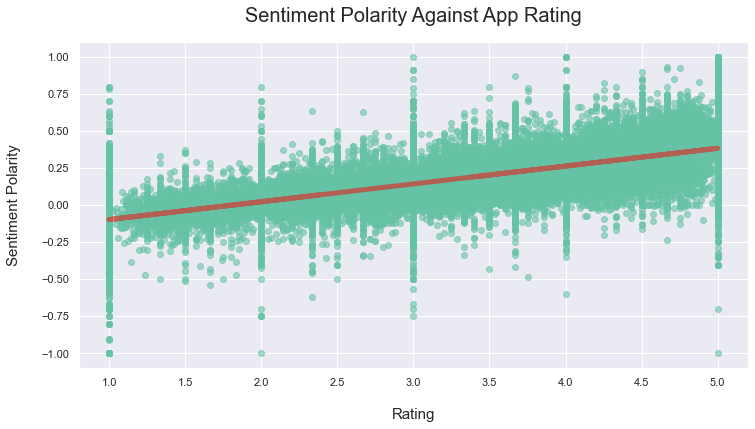

In [37]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

plt.scatter(grouped_reviews_google['mean_score'], grouped_reviews_google['mean_polarity'], alpha=0.6, color=palette[0])
axis.set_xlabel(xlabel='Rating', fontsize=15, labelpad=20)
axis.set_ylabel(ylabel='Sentiment Polarity', fontsize=15, labelpad=20)
axis.set_title(label='Sentiment Polarity Against App Rating', fontsize=20, pad=20)

fit = stats.linregress(grouped_reviews_google['mean_score'], grouped_reviews_google['mean_polarity'])
grouped_reviews_google['prediction'] = fit.slope*grouped_reviews_google['mean_score'] + fit.intercept
plt.plot('mean_score', 'prediction', data=grouped_reviews_google, color='red', linewidth=5, alpha=0.5)
plt.show()

Why are there still data comments with negative sentiments if they've received a rating of 5-stars? Let's investigate that. 

In [38]:
# From https://stackoverflow.com/questions/19913659/pandas-conditional-creation-of-a-series-dataframe-column
# Categorize polarity values into sentiments
conditions = [
    reviews_google['polarity'] > 0,
    reviews_google['polarity'] < 0,
    reviews_google['polarity'] == 0
]

sentiments = ['positive', 'negative', 'neutral']
reviews_google['Sentiment'] = np.select(conditions, sentiments, default='neutral')

In [39]:
five_star_reviews = reviews_google[reviews_google['score'] == 5]
five_star_reviews = five_star_reviews[five_star_reviews['Sentiment'] == 'negative']
five_star_reviews.head(5)

,Unnamed: 0,App Id,user_name,score,content,likes,polarity,App Name,Google Developer,Google Rating,Google Released,Google Rating Count,Sentiment
80,0.0,com.imangi.templerun2,Fancy Stache,5,"RIP Temple Run. Leaving at 5 stars as a thanks for all of the fun I've had over the years, but this overhaul is even worse when you guys added those clunky, flow breaking in game map changes years ago.",8349,-0.075000,Temple Run 2,Imangi Studios,4.2,"Jan 23, 2013",9649311.0,negative
82,0.0,com.imangi.templerun2,Ety Evie,5,"I like that when you go a long time without dieing your avatar becomes faster. It's kinda like a challenge, and I like those!",396,-0.062500,Temple Run 2,Imangi Studios,4.2,"Jan 23, 2013",9649311.0,negative
86,0.0,com.imangi.templerun2,Gus Romain,5,Fun game for when I have nothing important to do. You can just turn off ads by turning on airplane mode and the game still works.,269,-0.025000,Temple Run 2,Imangi Studios,4.2,"Jan 23, 2013",9649311.0,negative
92,0.0,com.imangi.templerun2,Margarita Rodriguez,5,Who designed this make over???? He or she has no idea of what they were doing!!! Terrible changes!!!! There is no way to play this game with so many crazy mistakes in it!!! Very dissapointing!!!!,101,-0.282344,Temple Run 2,Imangi Studios,4.2,"Jan 23, 2013",9649311.0,negative
95,0.0,com.imangi.templerun2,Scotty Bowman,5,Totally hooked on this game. Hardly any ads and just love playing it.,47,-0.047917,Temple Run 2,Imangi Studios,4.2,"Jan 23, 2013",9649311.0,negative


In [40]:
five_star_reviews[five_star_reviews['polarity'] == -1].head()

,Unnamed: 0,App Id,user_name,score,content,likes,polarity,App Name,Google Developer,Google Rating,Google Released,Google Rating Count,Sentiment
11290,0.0,com.dive.bed.game,Itz_Gatcha Wolf39,5,I MADE THE WORLD RECORD OF 250 FLIPS INSTALL THIS GAME AND BEAT ME RECORD!!!! P.S I PROBABLY GLITCHED BUT STILL!!!! 5 STARS!!! ALSO DON'T BELIVE EVERYONE ELSE!!! THEY LIEING Wait NO MAKE THAT 300 FLIPS!!!,11,-1.0,Bed Diving,"Geisha Tokyo, Inc.",3.5,"Mar 3, 2020",4058.0,negative
38508,0.0,com.peotv.peotvgo,rifai nazim,5,PEOTV GO IS NOT WORKING EVER SINCE I BOUGHT THE CONNECTION. REPEATED COMPLAINS TO 1212 YIELDED NO RESULTS!!!!! I AM DISGUSTED. WELL I GAVE FIVE STAR IS BECAUSE WHEN IT COMES TO INEFFICIENCY I COULD RATE 5!!!,6,-1.0,PEOTVGO,Sri Lanka Telecom PLC,3.1,"Mar 29, 2019",1049.0,negative
40988,0.0,com.cocoplay.cocoparty,A Google user,5,I like this game because I like the outfits and the makeup 😀😃😄😉but there's one thing that I don't like the time once I had to wait for 08 hour's! !!!!!!!,19,-1.0,Coco Party - Dancing Queens,Coco Play By TabTale,4.1,"May 12, 2015",181012.0,negative
42957,0.0,com.zuuks.bus.simulator.ultimate,James Rains,5,I like it and give it a five star. Because I like the way they give you a choice for camera position. And a stirring wheel or arrows two move the buses turns. This is why I like this game so if you don't like it do you boo. But it also takes time to download plz change that is it!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! !!!!!!!!!!!! By. Skylar Rae Rains,0,-1.0,Bus Simulator : Ultimate,Zuuks Games,4.3,"Jun 15, 2019",1258961.0,negative
56360,0.0,com.colorful3dfree,Zion Ilas,5,This is insane im not gonna lie,2,-1.0,Colorful 3D,Tran Minh Nhut,3.4,"Aug 21, 2015",6679.0,negative


It seems like all the 5-star reviews are clearly positive comments, but their in-game suggestions are interpreted as having negative sentiment. 

We will finish off this section by cheking if the mean polarity is different for the different review scores. 

In [41]:
one_star_reviews = reviews_google[reviews_google['score'] == 1]
two_star_reviews = reviews_google[reviews_google['score'] == 2]
three_star_reviews = reviews_google[reviews_google['score'] == 3]
four_star_reviews = reviews_google[reviews_google['score'] == 4]

In [42]:
f_oneway(one_star_reviews['polarity'], 
         two_star_reviews['polarity'],
         three_star_reviews['polarity'], 
         four_star_reviews['polarity'], 
         five_star_reviews['polarity'])

F_onewayResult(statistic=30939.705289873036, pvalue=0.0)

With a pvalue of (virtually) 0, we can conclude that at least one of the means are different. We explore further with Tukey's test to see which means are different.

In [43]:
results = pairwise_tukeyhsd(reviews_google['polarity'], reviews_google['score'])._results_table
results

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,0.0973,0.001,0.0943,0.1004,True
1,3,0.1703,0.001,0.1673,0.1732,True
1,4,0.2841,0.001,0.2815,0.2868,True
1,5,0.424,0.001,0.4222,0.4258,True
2,3,0.0729,0.001,0.0692,0.0767,True
2,4,0.1868,0.001,0.1833,0.1903,True
2,5,0.3267,0.001,0.3237,0.3296,True
3,4,0.1139,0.001,0.1104,0.1173,True
3,5,0.2537,0.001,0.2509,0.2565,True
4,5,0.1399,0.001,0.1374,0.1424,True


We can see that the means between every pair of group is different at an alpha of 0.05. The mean sentiment polarity between say, a rating of 4 and a rating of 5, is clearly distinguishable in this case. 

Next, we will explore the relationship between the number of likes that a review obtains and its sentiment polarity: are users more likely to 'thumbs up' reviews that are more postive or more negative? 

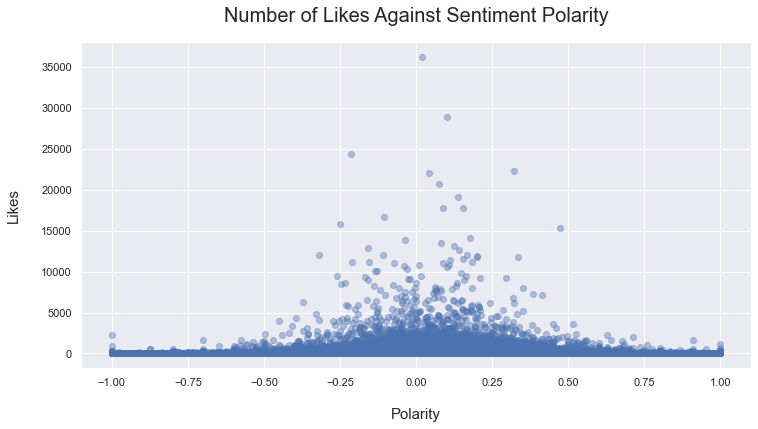

In [44]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

plt.scatter(reviews_google['polarity'], reviews_google['likes'], alpha=0.4)
axis.set_xlabel(xlabel='Polarity', fontsize=15, labelpad=20)
axis.set_ylabel(ylabel='Likes', fontsize=15, labelpad=20)
axis.set_title(label='Number of Likes Against Sentiment Polarity', fontsize=20, pad=20)

plt.show()

From the scatter plot, we can see that the most liked reviews are around 'neutral' in sentiment. 

Let's plot a distrubtion of sentiment polarities. 

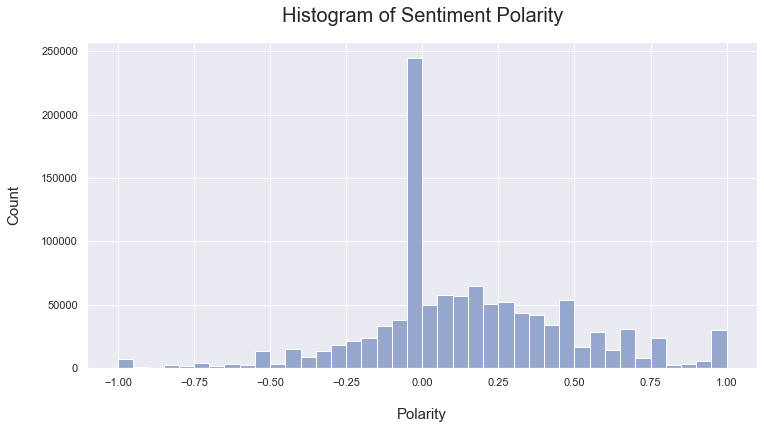

In [45]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

sns.histplot(reviews_google['polarity'], binwidth=0.05, alpha=0.9, color=palette[2])
axis.set_xlabel(xlabel='Polarity', fontsize=15, labelpad=20)
axis.set_ylabel(ylabel='Count', fontsize=15, labelpad=20)
axis.set_title(label='Histogram of Sentiment Polarity', fontsize=20, pad=20)

plt.show()


We see that an overwhelming majority of reviewshave a neutral sentiment polarity, which explains why they are the most liked!

Next, we will explore if a reviewer gives different reviews. We will consider users who have left more than 5 reviews. 

In [46]:
users = reviews_google.groupby(by=['user_name', 'score']).agg(num_reviews=('content', 'count'))
users = users[users['num_reviews'] > 5]
users.reset_index(inplace=True)

# Remove anonymous names and unidentifable names
users = users[users['user_name'] != 'A Google user']
users['user_name'] = users['user_name'].str.replace(r'\r\n|\r|;|-|--|\.|\s+|""|', '');
users['user_name'].replace('', np.nan, inplace=True)
users.dropna(inplace=True)

<ipython-input-46-cbcf8b843513>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  users['user_name'] = users['user_name'].str.replace(r'\r\n|\r|;|-|--|\.|\s+|""|', '');


In [47]:
users['full_score'] = users['score'] * users['num_reviews']

users_grouped = users.groupby(by=['user_name']).agg(total_reviews=('num_reviews', 'sum'), 
                                                    total_full_score=('full_score', 'sum'))
users_grouped.reset_index(inplace=True)

In [48]:
users_grouped['average_score'] = users_grouped['total_full_score'] / users_grouped['total_reviews']

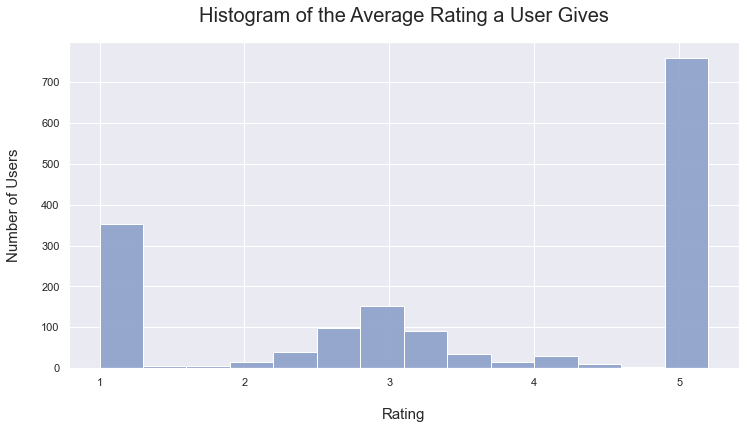

In [49]:
figure = plt.figure(figsize=(12, 6))
axis = plt.gca()

sns.histplot(users_grouped['average_score'], binwidth=0.3, alpha=0.9, color=palette[2])
axis.set_xlabel(xlabel='Rating', fontsize=15, labelpad=20)
axis.set_ylabel(ylabel='Number of Users', fontsize=15, labelpad=20)
axis.set_title(label='Histogram of the Average Rating a User Gives', fontsize=20, pad=20)

plt.show()

We can see that the average user rating is either very low or very high. There are more users who *solely* give positive ratings than users who *solely* give negative ones. Very few give a mixture of positive and negative ratings. 

We speculate that a user has more incentive to rate an application if it is either exemplary or deplorable. If it's somewhere in between, they may not have much to say and hence, refrain from reviewing. 

We acknowledge the limitation of this small sample size, however. It is not representative of the entire data set. Additionally, two users apparently are allowed to have the same user name!